# Experimento de Indexação Hash no PostgreSQL

Este notebook implementa um experimento para avaliar o desempenho de consultas SQL com volumes crescentes de dados, comparando o comportamento com e sem índices Hash.

Utilizaremos uma base de dados fictícia de uma biblioteca, com tabelas de usuários, livros e empréstimos.

In [29]:
# Imports necessários
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.db_connection import DatabaseConnection, execute_query
from utils.data_generator import BibliotecaDataGenerator
import numpy as np

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

## Configuração do Experimento

Primeiro, vamos configurar a conexão com o banco de dados e limpar quaisquer dados existentes para garantir um ambiente consistente para o experimento.

In [30]:
# Inicializa a conexão com o banco de dados
DatabaseConnection.init_connection_pool()

# Cria uma instância do gerador de dados
gerador = BibliotecaDataGenerator(seed=42)

# Limpa o banco de dados para começar do zero
gerador.limpar_banco()
print("Banco de dados limpo e pronto para o experimento.")

Pool de conexão inicializado com sucesso
Limpando o banco de dados...
Banco de dados limpo com sucesso.
Banco de dados limpo e pronto para o experimento.


## Definição da Consulta SQL para o Experimento

A consulta abaixo seleciona todos os livros que não foram emprestados pelo usuário com CPF específico.
Esta consulta envolve múltiplas junções e pode se beneficiar de índices adequados.

In [ ]:
# Definição da consulta SQL
query = """
SELECT l.*
FROM livros l
WHERE l.genero = 'Aventura'
AND NOT EXISTS (
    SELECT 1 
    FROM emprestimos e 
    INNER JOIN usuarios u ON u.id = e.usuario_id AND u.cpf = '532.710.165-59' 
    WHERE e.livro_id = l.id
);
"""

# Função para executar consulta com EXPLAIN ANALYZE e medir tempo
def executar_consulta_com_tempo(query, collect_stats=True):
    plan_stats = None
    if collect_stats:
        # Versão com EXPLAIN ANALYZE para obter estatísticas
        explain_query = f"EXPLAIN (ANALYZE, BUFFERS, FORMAT JSON) {query}"
        resultado_explain = execute_query(explain_query)

        # Extrair estatísticas
        plan_stats = resultado_explain.values[0][0][0]["Plan"]

    inicio = time.time()
    # Versão simples sem estatísticas
    resultado = execute_query(query)

    fim = time.time()
    tempo_execucao = fim - inicio

    return resultado, tempo_execucao, plan_stats

# Função para extrair informações sobre leituras de disco do plano de execução
def extrair_leituras_de_disco(plan_stats):
    """
    Extrai o número total de leituras de disco (shared_read + local_read) de um plano de execução.
    """
    if not plan_stats:
        return 0
        
    total_reads = 0
    
    # Processar o nó atual
    if 'Shared Read Blocks' in plan_stats:
        total_reads += plan_stats['Shared Read Blocks']
    if 'Local Read Blocks' in plan_stats:
        total_reads += plan_stats['Local Read Blocks']
    
    # Processar recursivamente os nós filhos
    if 'Plans' in plan_stats:
        for subplan in plan_stats['Plans']:
            total_reads += extrair_leituras_de_disco(subplan)
    
    return total_reads

# Função para criar índices hash
def criar_indices_hash():
    indices_sql = [
        "CREATE INDEX IF NOT EXISTS idx_hash_livros_genero ON livros USING hash(genero);",
        "CREATE INDEX IF NOT EXISTS idx_hash_usuarios_cpf ON usuarios USING hash(cpf);",
        "CREATE INDEX IF NOT EXISTS idx_hash_emprestimos_livro_id ON emprestimos USING hash(livro_id);",
    ]
    
    print("Criando índices hash...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices hash criados com sucesso.")

# Função para remover índices hash
def remover_indices_hash():
    indices_sql = [
        "DROP INDEX IF EXISTS idx_hash_livros_genero;",
        "DROP INDEX IF EXISTS idx_hash_usuarios_cpf;",
        "DROP INDEX IF EXISTS idx_hash_emprestimos_livro_id;",
    ]
    
    print("Removendo índices hash...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices hash removidos com sucesso.")

## Experimento: Consultas com e sem Índices

Nesta parte, vamos executar a consulta com volumes crescentes de dados, alternando entre execuções com e sem índices hash.
A cada iteração:
1. Adicionamos mais registros ao banco
2. Executamos a consulta sem índices e medimos o tempo
3. Criamos os índices hash
4. Executamos a consulta com índices e medimos o tempo
5. Removemos os índices para a próxima iteração

In [32]:
# Parâmetros do experimento
num_iteracoes = 8
registros_por_iteracao = 250000
proporcao_usuarios = 0.10  # 10% dos registros serão usuários
proporcao_livros = 0.30  # 30% dos registros serão livros
proporcao_emprestimos = 0.60  # 60% dos registros serão empréstimos

# Armazenar resultados
resultados_experimento = {
    "total_registros": [],
    "tempo_sem_indices": [],
    "tempo_com_indices": [],
    "num_resultados": [],
    "leituras_sem_indices": [],  # Novo - armazenar número de leituras de disco
    "leituras_com_indices": [],  # Novo - armazenar número de leituras de disco
}

# Registrar total inicial
total_registros = 0

# Loop de experimento: adicionar dados e medir tempo
for i in range(0, num_iteracoes):
    print(f"\n{'=' * 50}")
    print(f"ITERAÇÃO {i + 1}: Adicionando mais {registros_por_iteracao} registros...")
    print(f"{'=' * 50}")

    # Calcular quantos registros de cada tipo adicionar
    adicionar_usuarios = int(registros_por_iteracao * proporcao_usuarios)
    adicionar_livros = int(registros_por_iteracao * proporcao_livros)
    adicionar_emprestimos = (
        registros_por_iteracao - adicionar_usuarios - adicionar_livros
    )

    # Adicionar registros
    resultado_batch = gerador.popular_banco(
        num_usuarios=adicionar_usuarios,
        num_livros=adicionar_livros,
        num_emprestimos=adicionar_emprestimos,
    )

    # Atualizar total de registros
    registros_adicionados = sum(resultado_batch.values())
    total_registros += registros_adicionados
    resultados_experimento["total_registros"].append(total_registros)

    print(f"\nTotal de registros agora: {total_registros}")

    # 1. Executar consulta SEM índices e medir tempo
    print("\n1. Executando consulta SEM índices...")
    resultado, tempo_sem_indices, stats_sem_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_sem_indices"].append(tempo_sem_indices)
    resultados_experimento["num_resultados"].append(len(resultado))
    
    # Extrair leituras de disco
    leituras_sem_indices = extrair_leituras_de_disco(stats_sem_indices)
    resultados_experimento["leituras_sem_indices"].append(leituras_sem_indices)
    
    print(
        f"Consulta SEM índices executada em {tempo_sem_indices:.4f} segundos, retornando {len(resultado)} registros."
    )
    print(f"Número de leituras de disco sem índices: {leituras_sem_indices}")

    # 2. Criar índices hash
    print("\n2. Criando índices hash...")
    criar_indices_hash()

    # 3. Executar consulta COM índices e medir tempo
    print("\n3. Executando consulta COM índices hash...")
    resultado, tempo_com_indices, stats_com_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_com_indices"].append(tempo_com_indices)
    
    # Extrair leituras de disco
    leituras_com_indices = extrair_leituras_de_disco(stats_com_indices)
    resultados_experimento["leituras_com_indices"].append(leituras_com_indices)
    
    print(
        f"Consulta COM índices hash executada em {tempo_com_indices:.4f} segundos, retornando {len(resultado)} registros."
    )
    print(f"Número de leituras de disco com índices: {leituras_com_indices}")

    # 4. Remover índices para a próxima iteração
    print("\n4. Removendo índices para a próxima iteração...")
    remover_indices_hash()

print("\nExperimento concluído com sucesso!")


ITERAÇÃO 1: Adicionando mais 250000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 25000 usuários...
Total de 22351 usuários inseridos.
Gerando 75000 livros...
Total de 75000 livros inseridos.
Gerando 150000 empréstimos...
Total de 150000 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de registros agora: 247351

1. Executando consulta SEM índices...
Consulta SEM índices executada em 0.0611 segundos, retornando 3791 registros.
Número de leituras de disco sem índices: 0

2. Criando índices hash...
Criando índices hash...
Índices hash criados com sucesso.

3. Executando consulta COM índices hash...
Consulta COM índices hash executada em 0.0540 segundos, retornando 3791 registros.
Número de leituras de disco com índices: 0

4. Removendo índices para a próxima iteração...
Removendo índices hash...
Índices hash removidos com sucesso.

ITERAÇÃO 2: Adicionando mais 250000 registros...
Iniciando populamento do banco de dados.

## Resultados do Experimento

Vamos visualizar os resultados comparativos entre consultas com e sem índices hash.

Resultados do Experimento:
   Total de Registros  Tempo sem Índices (s)  Tempo com Índices Hash (s)  \
0              247351               0.061126                    0.053962   
1              490990               0.212032                    0.091497   
2              732287               0.153981                    0.144973   
3              971913               0.235907                    0.317977   
4             1210441               0.262460                    0.760204   
5             1447957               0.298339                    0.375456   
6             1684352               0.478114                    0.410072   
7             1919818               0.631076                    0.908502   

   Leituras de Disco sem Índices  Leituras de Disco com Índices  \
0                              0                              0   
1                              0                            676   
2                          14151                          11038   
3                   

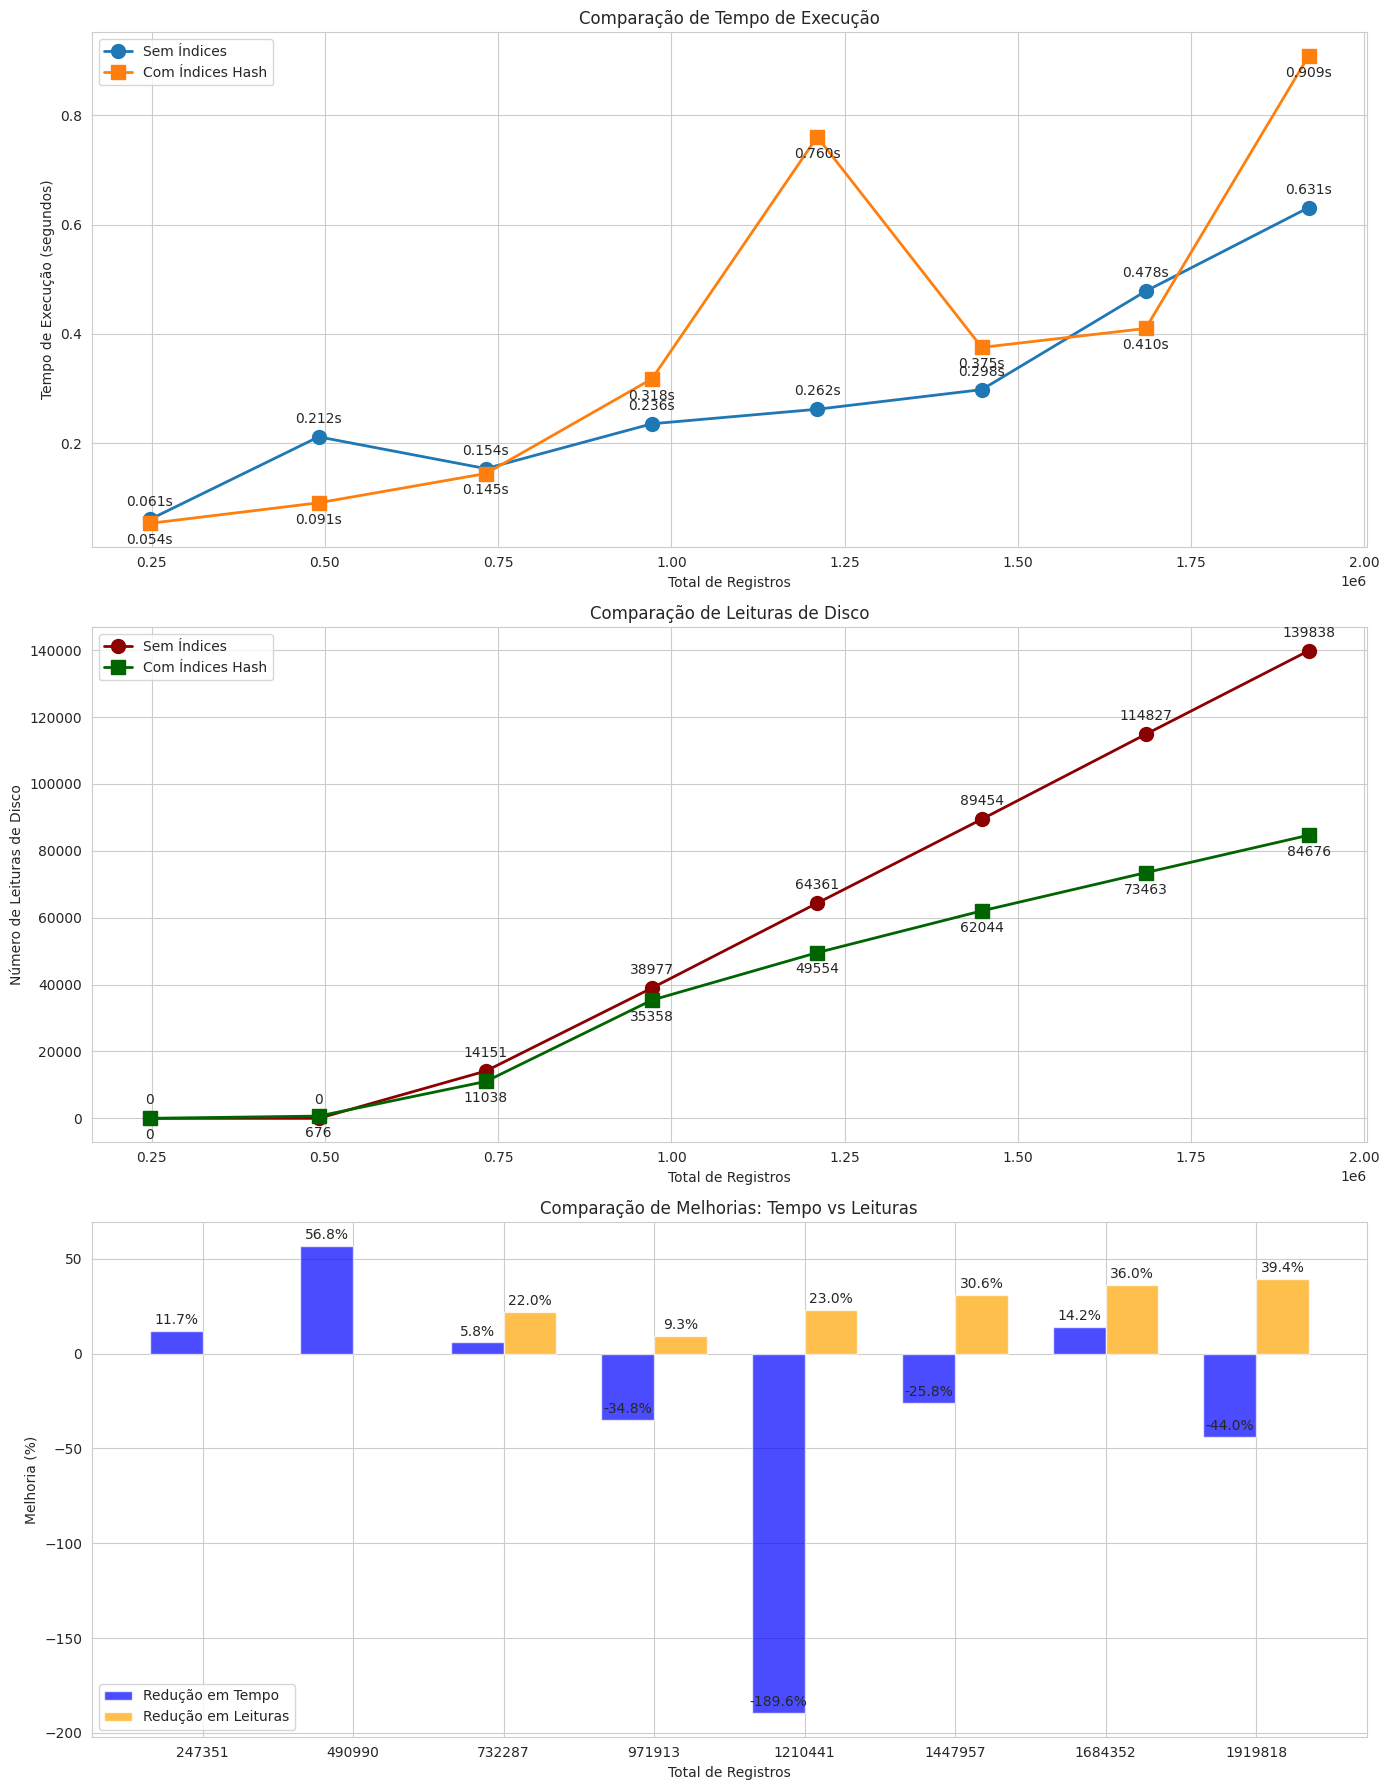

In [33]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Total de Registros': resultados_experimento['total_registros'],
    'Tempo sem Índices (s)': resultados_experimento['tempo_sem_indices'],
    'Tempo com Índices Hash (s)': resultados_experimento['tempo_com_indices'],
    'Leituras de Disco sem Índices': resultados_experimento['leituras_sem_indices'],
    'Leituras de Disco com Índices': resultados_experimento['leituras_com_indices'],
    'Número de Resultados': resultados_experimento['num_resultados'],
})

# Calcular as melhorias percentuais
df_resultados['Melhoria em Tempo (%)'] = (1 - df_resultados['Tempo com Índices Hash (s)'] / df_resultados['Tempo sem Índices (s)']) * 100
df_resultados['Redução em Leituras (%)'] = (1 - df_resultados['Leituras de Disco com Índices'] / df_resultados['Leituras de Disco sem Índices']) * 100

# Exibir tabela de resultados
print("Resultados do Experimento:")
print(df_resultados)

# Criar três subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# 1. Gráfico de tempo de execução
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo sem Índices (s)'], 'o-', linewidth=2, markersize=10, label='Sem Índices')
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo com Índices Hash (s)'], 's-', linewidth=2, markersize=10, label='Com Índices Hash')
ax1.set_xlabel('Total de Registros')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.set_title('Comparação de Tempo de Execução')
ax1.legend()
ax1.grid(True)

# Adicionar rótulos para ambas as linhas do gráfico 1
for i, row in df_resultados.iterrows():
    ax1.annotate(f"{row['Tempo sem Índices (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo sem Índices (s)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax1.annotate(f"{row['Tempo com Índices Hash (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo com Índices Hash (s)']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# 2. Gráfico de leituras de disco
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco sem Índices'], 'o-', linewidth=2, markersize=10, color='darkred', label='Sem Índices')
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco com Índices'], 's-', linewidth=2, markersize=10, color='darkgreen', label='Com Índices Hash')
ax2.set_xlabel('Total de Registros')
ax2.set_ylabel('Número de Leituras de Disco')
ax2.set_title('Comparação de Leituras de Disco')
ax2.legend()
ax2.grid(True)

# Adicionar rótulos para ambas as linhas do gráfico 2
for i, row in df_resultados.iterrows():
    ax2.annotate(f"{int(row['Leituras de Disco sem Índices'])}",
                xy=(row['Total de Registros'], row['Leituras de Disco sem Índices']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax2.annotate(f"{int(row['Leituras de Disco com Índices'])}",
                xy=(row['Total de Registros'], row['Leituras de Disco com Índices']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# 3. Gráfico de barras para percentual de melhoria (tempo e leituras)
width = 0.35
x = df_resultados['Total de Registros']
x_pos = range(len(x))

ax3.bar(np.array(x_pos) - width/2, df_resultados['Melhoria em Tempo (%)'], width, label='Redução em Tempo', color='blue', alpha=0.7)
ax3.bar(np.array(x_pos) + width/2, df_resultados['Redução em Leituras (%)'], width, label='Redução em Leituras', color='orange', alpha=0.7)
ax3.set_xlabel('Total de Registros')
ax3.set_ylabel('Melhoria (%)')
ax3.set_title('Comparação de Melhorias: Tempo vs Leituras')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_resultados['Total de Registros'])
ax3.legend()
ax3.grid(True, axis='y')

# Adicionar valores em cada barra
for i, row in df_resultados.iterrows():
    ax3.annotate(f"{row['Melhoria em Tempo (%)']:.1f}%",
                xy=(i - width/2, row['Melhoria em Tempo (%)']),
                textcoords="offset points",
                xytext=(0,5),
                ha='center')
    ax3.annotate(f"{row['Redução em Leituras (%)']:.1f}%",
                xy=(i + width/2, row['Redução em Leituras (%)']),
                textcoords="offset points",
                xytext=(0,5),
                ha='center')

plt.tight_layout()
plt.show()

In [34]:
# Fechar conexões com o banco de dados ao finalizar
DatabaseConnection.close_all_connections()
print("Conexões com o banco de dados fechadas.")

Conexões com o banco de dados fechadas.


## Conclusão

Os índices hash são especialmente bons para consultas que envolvem o operador de igualdade (=), porém, nessa consulta em específico, não se observou grande ganho no que diz respeito ao tempo de execução. A máquina certamente influência, porém, o tempo, para o uso de índices varia muito, ao passo que sem eles, segue um certo padrão. E os resultados com índice frequentemente são piores.
O ganho que se obteve no experimento, foi em relação ao número de leituras realizadas no disco, que na últuma iteração ficou na casa dos 40% com tendência de melhora, ao olhar para o gráfico.
Por conta da máquina em que os testes foram realizados, a diferença entre os tempos de execução é ínfima.